In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_continuous import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [3]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.1
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 6.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

batchsize = 64
num_envs = 8
num_updates = 2000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": batchsize,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(batchsize * num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [4]:
single_train = jit(PPO_make_train(config), static_argnums=(-2, -1))

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    kappa,
    chi,
    kerr,
    time_coeff,
    snr_coeff,
    smoothness_coeff,
    n0,
    tau_0,
    res_amp_scaling,
    nR,
    snr_scale_factor,
    gamma_I,
    photon_gamma,
    num_t1,
    init_fid,
    photon_weight,
    batchsize, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 2000 Updates
global update: 100
mean batch reward: [-17.64526814 -13.69843736 -13.70469853 -16.14403521 -19.09063648
 -14.23503198 -17.29434571 -16.07390911]
mean batch pF: [2.55753386 2.55794482 2.55573795 2.54958434 2.55529724 2.5572152
 2.55723035 2.55884488]
mean batch photon: [35.33548737 34.72065353 34.66419983 34.06518173 35.8657341  33.80659485
 34.01438904 35.09656525]
mean batch photon time: [0.35476903 0.34680911 0.34646447 0.35804491 0.35099852 0.36274663
 0.33369798 0.36530164]
mean batch smoothness: [0.00567951 0.00390155 0.00660172 0.00334585 0.00841601 0.00560421
 0.00683036 0.00591932]
max reward obtained: [4.00919871 7.62422527 7.58964076 9.86005628 7.60868716 6.83886343
 5.67123913 3.88525825]
pF at max: [2.55901379 2.56241348 2.56678183 2.54898533 2.55495352 2.5406433
 2.54482401 2.5673757 ]
photon at max: [33.63909531 37.94116974 39.09430695 27.41259003 32.01144409 29.27434731
 33.99581146 43.99240494]
photon time of max: [0.30781677 0.45504282 0.

In [8]:
# Extracting Results

metrics = single_result["metrics"]

max_actions = metrics["action of max"]
max_rewards = metrics["max reward obtained"]
max_photons = metrics["photon at max"]
max_pFs = metrics["pF at max"]
max_times = metrics["photon time of max"]
max_smoothness = metrics["smoothness at max"]
mean_rewards = metrics["mean batch reward"]
mean_pFs = metrics["mean batch pF"]
mean_photons = metrics["mean batch photon"]
mean_photon_times = metrics["mean batch photon time"]
mean_smoothness = metrics["mean batch smoothness"]
std_reward = metrics["std batch reward"]

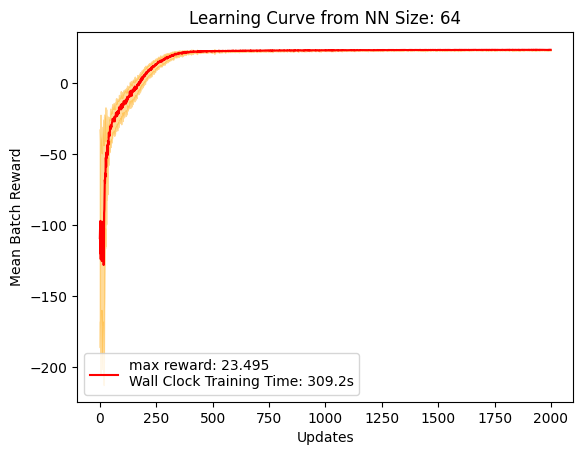

In [9]:
env_ind = 0
update_plot = 2000

x = np.arange(update_plot) # / update_plot * (end - start)
m_plot = mean_rewards[:update_plot, env_ind]
s_plot = std_reward[:update_plot, env_ind]

plt.plot(x, m_plot, label=f'max reward: {int(1e3 * max_rewards[-1,0]) / 1e3}\nWall Clock Training Time: {int(1e1 *(end - start)) / 1e1}s', color='red')
plt.fill_between(x, m_plot - s_plot, m_plot + s_plot, color='orange', alpha=0.4)
plt.legend()
plt.xlabel('Updates')
plt.ylabel('Mean Batch Reward')
plt.title(f'Learning Curve from NN Size: {config["LAYER_SIZE"]}')
plt.show()

(2000, 8, 121)
0.05666666666666668
0.3078167720360949
0.22500000000000003


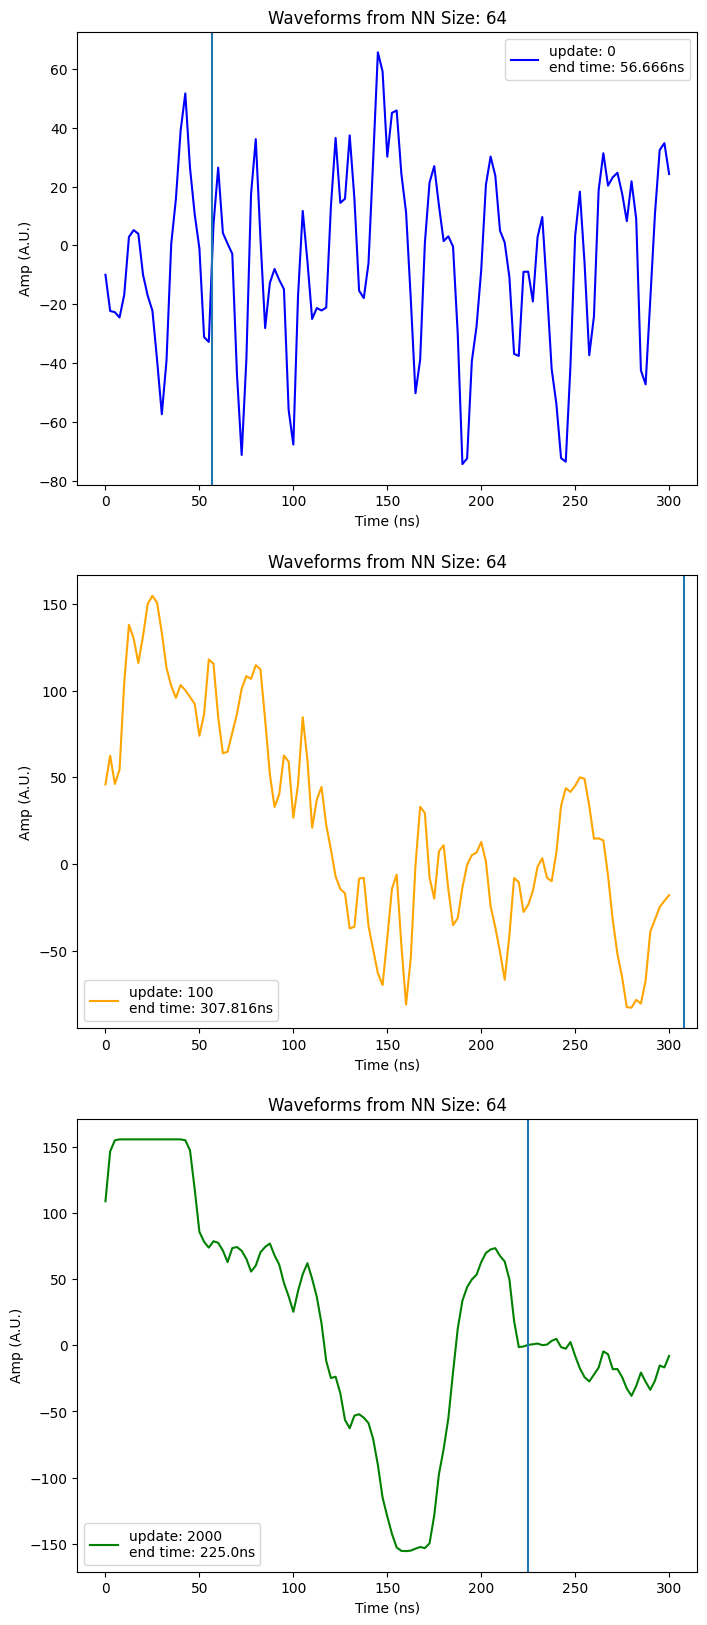

In [10]:
# Visualising Waveform Learning

plotting_updates = np.array([0, 100, 2000], dtype=np.int16)

print(max_actions.shape)

update_action = -max_actions[plotting_updates, 0]
action_linspace = np.linspace(0., num_t1 / kappa, update_action.shape[-1])

fig, ax = plt.subplots(len(plotting_updates), figsize=(8.0, 20.0))

color_list = ["blue", "orange", "green"]

for ind, action in enumerate(update_action):
    ax[ind].plot(action_linspace * 1e3, action, label=f'update: {plotting_updates[ind]}\nend time: {int(1e6 * max_times[plotting_updates[ind], 0]) / 1e3}ns', color=color_list[ind])
    ax[ind].axvline(x=1e6 * max_times[plotting_updates[ind], 0] / 1e3)
    print(max_times[plotting_updates[ind], 0])
    ax[ind].legend()
    ax[ind].set_xlabel('Time (ns)')
    ax[ind].set_ylabel('Amp (A.U.)')
    ax[ind].set_title(f'Waveforms from NN Size: {config["LAYER_SIZE"]}')
plt.show()